# 7. HAFTA Brain tumor ve PLant

## Kurulum & Ortam

In [23]:

import os, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Tekrarlanabilirlik
SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# Tek klasör yapısı
BASE = r"C:\Users\The Coder Farmer\Desktop\AI LAB"
LEAVES_ROOT = rf"{BASE}\leaves"              # Plant 
BRAIN_ROOT  = rf"{BASE}\brain_tumor"         # Brain Tumor 
MODELS_DIR  = rf"{BASE}\models"
Path(MODELS_DIR).mkdir(parents=True, exist_ok=True)

AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE  = (128,128)
BATCH     = 32

print("TF:", tf.__version__)
print("BASE:", BASE)


TF: 2.19.0
BASE: C:\Users\The Coder Farmer\Desktop\AI LAB


## Yardımcı Fonksiyonlar (DataLoader, Model, Grafik)

In [24]:
def make_datasets_from_dir(root_dir, img_size=(128,128), batch_size=32, val_split=0.2):
    """root_dir altında sınıf klasörleri varsa; %val_split kadar validation ayırır."""
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        root_dir, validation_split=val_split, subset="training", seed=SEED,
        label_mode="categorical", image_size=img_size, batch_size=batch_size
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        root_dir, validation_split=val_split, subset="validation", seed=SEED,
        label_mode="categorical", image_size=img_size, batch_size=batch_size
    )
    classes = train_ds.class_names
    return train_ds.prefetch(AUTOTUNE), val_ds.prefetch(AUTOTUNE), classes

def make_datasets_from_train_valid(train_dir, valid_dir, img_size=(128,128), batch_size=32):
    """train/ ve valid/ ayrı klasör ise bunu kullan."""
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir, seed=SEED, label_mode="categorical",
        image_size=img_size, batch_size=batch_size
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        valid_dir, seed=SEED, label_mode="categorical",
        image_size=img_size, batch_size=batch_size
    )
    classes = train_ds.class_names
    return train_ds.prefetch(AUTOTUNE), val_ds.prefetch(AUTOTUNE), classes

def find_train_valid_under(root):
    """leaves altında train/valid ister doğrudan ister bir üst klasör içinde olsun, otomatik bulur."""
    root = Path(root)
    train_dir = root / "train" if (root / "train").exists() else None
    valid_dir = root / "valid" if (root / "valid").exists() else None
    if train_dir is None:  # alt klasörlerde ara (bazı Kaggle zip'leri üst klasörle gelir)
        for p in root.rglob("train"):
            if p.is_dir(): train_dir = p; break
    if valid_dir is None:
        for p in root.rglob("valid"):
            if p.is_dir(): valid_dir = p; break
    return train_dir, valid_dir

def build_cnn(num_classes, img_shape=(128,128,3)):
    """[Soru-1] Kendi ESA (CNN) mimarimiz."""
    aug = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ], name="augment")

    inp = keras.Input(shape=img_shape)
    x = aug(inp)
    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x); x = layers.MaxPooling2D()(x)

    x = layers.Dropout(0.25)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.25)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inp, out, name="ESA_CNN")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

def plot_history(h, title="History"):
    plt.figure(figsize=(6,4))
    plt.plot(h.history["loss"]); plt.plot(h.history["val_loss"])
    plt.title(title+" - Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(["train","val"]); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(h.history["accuracy"]); plt.plot(h.history["val_accuracy"])
    plt.title(title+" - Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend(["train","val"]); plt.show()

def evaluate_with_f1(model, ds, class_names):
    y_true, y_pred = [], []
    for x, y in ds:
        p = model.predict(x, verbose=0)
        y_true.extend(np.argmax(y.numpy(), axis=1))
        y_pred.extend(np.argmax(p, axis=1))
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    acc = (y_true == y_pred).mean()
    f1  = f1_score(y_true, y_pred, average="macro")
    print(f"Validation Accuracy: {acc:.4f} | F1 (macro): {f1:.4f}")
    print("\nSınıf Bazlı Rapor:\n", classification_report(y_true, y_pred, target_names=class_names))
    return acc, f1, (y_true, y_pred)


## SORU 1 VE 2 :  Kendi Modelini Kur + Farklı Epoch Denemeleri (Plant veri seti)

In [25]:
# Plant köklerini bul 
train_dir, valid_dir = find_train_valid_under(LEAVES_ROOT)
assert (train_dir is not None) or Path(LEAVES_ROOT).exists(), \
    "Plant verisi bulunamadı. 'AI LAB\\leaves' altına 'train' (opsiyonel 'valid') koy ve hücreyi tekrar çalıştır."

if train_dir and valid_dir and train_dir.exists() and valid_dir.exists():
    print("Ayrı klasör: train + valid kullanılıyor.")
    train_ds_leaf, val_ds_leaf, leaf_classes = make_datasets_from_train_valid(
        str(train_dir), str(valid_dir), img_size=IMG_SIZE, batch_size=BATCH
    )
else:
    use_root = str(train_dir) if train_dir else LEAVES_ROOT
    print("Tek kök: %20 validation ayrılacak =>", use_root)
    train_ds_leaf, val_ds_leaf, leaf_classes = make_datasets_from_dir(
        use_root, img_size=IMG_SIZE, batch_size=BATCH, val_split=0.2
    )

num_leaf_classes = len(leaf_classes)
print("Sınıf sayısı:", num_leaf_classes, "| Örnek sınıflar:", leaf_classes[:5])


Ayrı klasör: train + valid kullanılıyor.
Found 3751 files belonging to 2 classes.
Found 938 files belonging to 2 classes.
Sınıf sayısı: 2 | Örnek sınıflar: ['Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus']


In [26]:
# [Soru-1] Modeli kur ve özetini göster
leaf_model_template = build_cnn(num_leaf_classes, img_shape=(*IMG_SIZE,3))
leaf_model_template.summary()


Model: "ESA_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,938 (16.36 MB)

 Trainable params: 4,287,938 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


In [28]:
train_ds_leaf = train_ds_leaf.cache().prefetch(tf.data.AUTOTUNE)
val_ds_leaf   = val_ds_leaf.cache().prefetch(tf.data.AUTOTUNE)



=== Plant Eğitim — 5 epoch ===
Epoch 1/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.7738 - loss: 0.4512 - val_accuracy: 0.9552 - val_loss: 0.1388
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 24s 202ms/step - accuracy: 0.9641 - loss: 0.1015 - val_accuracy: 0.9701 - val_loss: 0.1241
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 199ms/step - accuracy: 0.9892 - loss: 0.0332 - val_accuracy: 0.9232 - val_loss: 0.2833
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 24s 202ms/step - accuracy: 0.9782 - loss: 0.0711 - val_accuracy: 0.9904 - val_loss: 0.0470
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 26s 218ms/step - accuracy: 0.9919 - loss: 0.0209 - val_accuracy: 0.7249 - val_loss: 1.1652

=== Plant Eğitim — 10 epoch ===
Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 26s 204ms/step - accuracy: 0.7702 - loss: 0.5240 - val_accuracy: 0.9733 - val_loss: 0.0664
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 25s 209ms/step - accuracy: 0.9650 - loss: 0.0953 - val_accuracy: 0.9957 - val_loss: 0.0116
Epoch 3/10
118/118 ━━━━

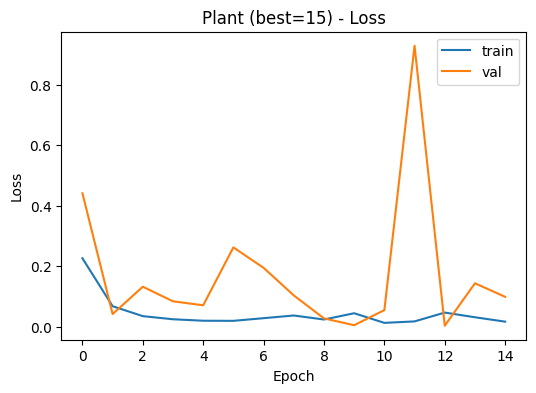

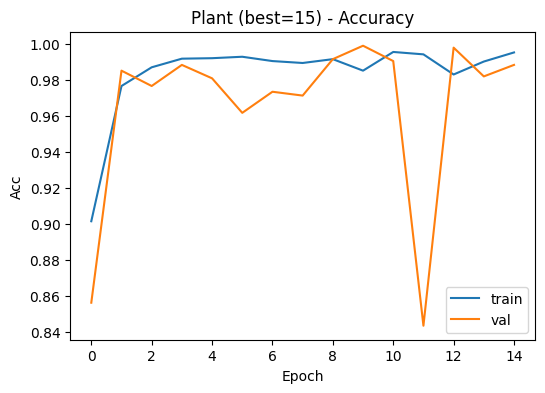

In [29]:
# [Soru-2] Farklı epoch denemeleri ve en iyi epoch'un seçimi
epoch_list = [5, 10, 15]
leaf_histories, scores = {}, []

for ep in epoch_list:
    print(f"\n=== Plant Eğitim — {ep} epoch ===")
    m = keras.models.clone_model(leaf_model_template)
    m.set_weights(leaf_model_template.get_weights())
    m.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy", metrics=["accuracy"])
    h = m.fit(train_ds_leaf, validation_data=val_ds_leaf, epochs=ep, verbose=1)
    leaf_histories[ep] = (m, h)
    best_val_acc = float(np.max(h.history["val_accuracy"]))
    scores.append((ep, best_val_acc))

scores_sorted = sorted(scores, key=lambda x: x[1], reverse=True)
best_epoch, best_acc = scores_sorted[0]
print("\nDenemeler:", scores)
print(f"En iyi epoch: {best_epoch} (val_acc={best_acc:.4f})")

best_leaf_model, best_leaf_hist = leaf_histories[best_epoch]
plot_history(best_leaf_hist, title=f"Plant (best={best_epoch})")


## SORU 3 :  Plant: Accuracy, F1, Loss Grafik + Tahmin

In [30]:
# Metrikler (accuracy + F1)
leaf_acc, leaf_f1, (leaf_y_true, leaf_y_pred) = evaluate_with_f1(best_leaf_model, val_ds_leaf, leaf_classes)


Validation Accuracy: 0.9883 | F1 (macro): 0.9883

Sınıf Bazlı Rapor:
                                         precision    recall  f1-score   support

Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.98      0.99       490
          Tomato___Tomato_mosaic_virus       0.98      1.00      0.99       448

                              accuracy                           0.99       938
                             macro avg       0.99      0.99      0.99       938
                          weighted avg       0.99      0.99      0.99       938



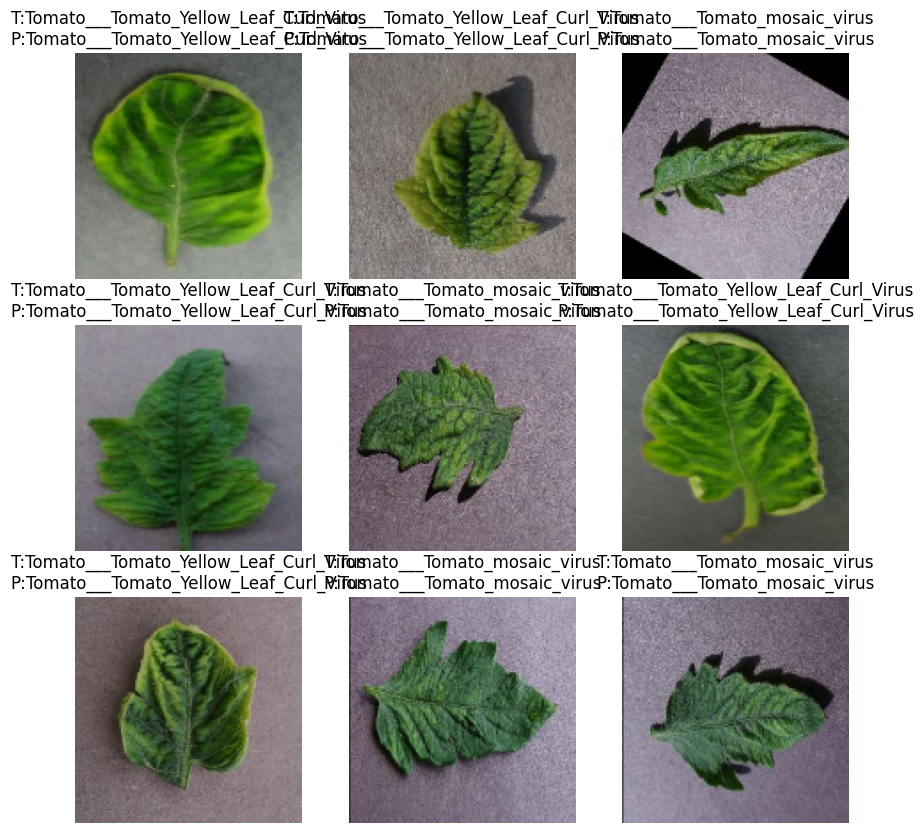

In [31]:
# Örnek tahmin görselleştirme
def show_sample_predictions(ds, model, class_names, n=9):
    imgs, labels = next(iter(ds.unbatch().batch(n)))
    preds = model.predict(imgs, verbose=0)
    plt.figure(figsize=(10,10))
    for i in range(n):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(imgs[i].numpy().astype("uint8")); plt.axis("off")
        t = class_names[np.argmax(labels[i].numpy())]
        p = class_names[np.argmax(preds[i])]
        plt.title(f"T:{t}\nP:{p}")
    plt.show()

show_sample_predictions(val_ds_leaf, best_leaf_model, leaf_classes, n=9)


In [32]:
#  Modeli kaydet
leaf_model_path = Path(MODELS_DIR, f"leaf_best_epoch{best_epoch}.keras")
best_leaf_model.save(leaf_model_path)
print("Kaydedildi:", leaf_model_path)


Kaydedildi: C:\Users\The Coder Farmer\Desktop\AI LAB\models\leaf_best_epoch15.keras


## SORU 4 : Brain Tumor: Accuracy/Loss Grafik + Confusion Matrix

In [33]:
# Brain Tumor: 'Training' kökünden %20 validation ayır
bt_train_dir = Path(BRAIN_ROOT, "Training")
assert bt_train_dir.exists(), "Brain Tumor 'Training' klasörü bulunamadı."

train_ds_bt, val_ds_bt, bt_classes = make_datasets_from_dir(
    str(bt_train_dir), img_size=IMG_SIZE, batch_size=BATCH, val_split=0.2
)
print("Sınıflar:", bt_classes)


Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Sınıflar: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


Model: "ESA_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,196 (16.36 MB)

 Trainable params: 4,288,196 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 230ms/step - accuracy: 0.4253 - loss: 1.2503 - val_accuracy: 0.5749 - val_loss: 0.9409
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 244ms/step - accuracy: 0.5751 - loss: 0.9655 - val_accuracy: 0.6463 - val_loss: 0.7806
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.6497 - loss: 0.8274 - val_accuracy: 0.7387 - val_loss: 0.6894
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 215ms/step - accuracy: 0.6920 - loss: 0.7360 - val_accuracy: 0.7735 - val_loss: 0.5933
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 215ms/step - accuracy: 0.7257 - loss: 0.6400 - val_accuracy: 0.7805 - val_loss: 0.5731
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step - accuracy: 0.7338 - loss: 0.6272 - val_accuracy: 0.7561 - val_loss: 0.5906
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 215ms/step - accuracy: 0.7649 - loss: 0.5613 - val_accuracy: 0.8014 - val_loss: 0.4908
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.7536 - loss: 0.5480 - val_accu

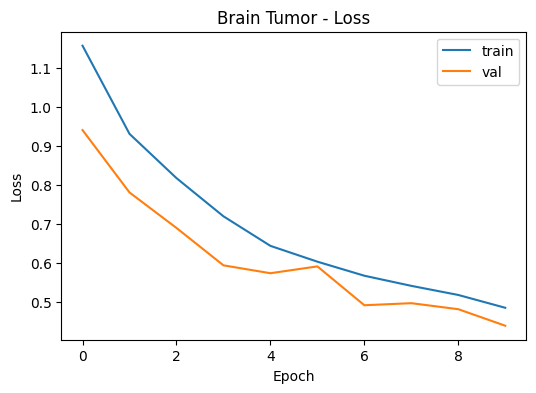

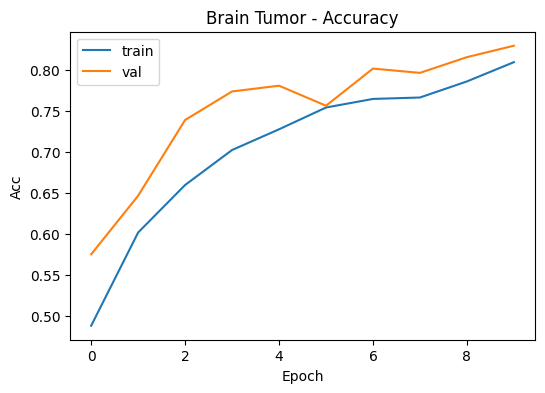

In [34]:
bt_model = build_cnn(num_classes=len(bt_classes), img_shape=(*IMG_SIZE,3))
bt_model.summary()

bt_hist = bt_model.fit(train_ds_bt, validation_data=val_ds_bt, epochs=10, verbose=1)
plot_history(bt_hist, title="Brain Tumor")


Brain Tumor — Validation Accuracy: 0.8293


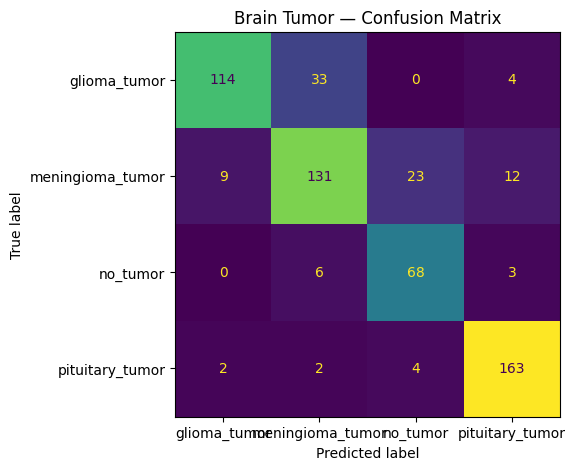

In [35]:
# Confusion Matrix (validation üzerinde)
y_true, y_pred = [], []
for x, y in val_ds_bt:
    p = bt_model.predict(x, verbose=0)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(p, axis=1))
y_true = np.array(y_true); y_pred = np.array(y_pred)

acc_bt = (y_true == y_pred).mean()
print(f"Brain Tumor — Validation Accuracy: {acc_bt:.4f}")

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(bt_classes))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bt_classes)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, colorbar=False)
plt.title("Brain Tumor — Confusion Matrix"); plt.show()


In [36]:
#  Modeli kaydet
bt_model_path = Path(MODELS_DIR, "brain_tumor_model.keras")
bt_model.save(bt_model_path)
print("Kaydedildi:", bt_model_path)


Kaydedildi: C:\Users\The Coder Farmer\Desktop\AI LAB\models\brain_tumor_model.keras
